# Viewpoint Classification (Front/Side/Back) Using YOLO12

**Task:** Classify traffic sign viewpoint using YOLO detection  
**Data Source:** signs.json (Label Studio export)  
**Classes:** Front, Side, Back (derived from viewing_angle)

In [ ]:
import os
os.environ['ULTRALYTICS_DISABLE_ANALYTICS'] = '1'

import json
import shutil
import warnings
from pathlib import Path
from collections import Counter
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.model_selection import train_test_split

try:
    from ultralytics import YOLO
    import ultralytics
    print(f"Ultralytics: {ultralytics.__version__}")
except ImportError:
    raise ImportError("pip install ultralytics")

warnings.filterwarnings('ignore')

class Config:
    SignJsonPath = "signs.json"
    ImageRoot = "signs_coco/images" 
    OutputDir = "data/viewpoint_yolo"
    ModelDir = "outputs/viewpoint_model"
    
    # YOLO config
    ModelType = "yolo12n"  
    ImgSize = 640
    BatchSize = 16
    Epochs = 100
    Patience = 15
    Device = 0
    
    ViewClasses = ['Front', 'Side', 'Back', 'Angle']

os.makedirs(Config.OutputDir, exist_ok=True)
os.makedirs(Config.ModelDir, exist_ok=True)
print(f"Setup complete. Device: {Config.Device}")

Ultralytics: 8.4.9
Setup complete. Device: 0


## Step One: Parse Signs.Json And Extract Viewpoint Labels

In [ ]:
def parse_labelstudio_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    annotations = []
    viewpoint_counts = Counter()
    
    for task in data:
        task_id = task.get('id')
        image_file = task.get('file_upload', '').replace('upload-', '')
        
        if 'data' in task and 'image' in task['data']:
            img_path = task['data']['image'].replace('/data/upload/', '')
        else:
            img_path = image_file
        
        for ann in task.get('annotations', []):
            for result in ann.get('result', []):
                if result.get('from_name') != 'viewing_angle':
                    continue
                
                value = result.get('value', {})
                viewing_angle = value.get('choices', [None])[0]
                
                if not viewing_angle:
                    continue
                
                bbox = None
                result_id = result.get('id')
                
                for r in ann.get('result', []):
                    if r.get('id') == result_id and r.get('type') == 'rectanglelabels':
                        v = r.get('value', {})
                        bbox = {
                            'x': v.get('x'),
                            'y': v.get('y'),
                            'width': v.get('width'),
                            'height': v.get('height')
                        }
                        sign_type = v.get('rectanglelabels', ['Unknown'])[0]
                        break
                
                if bbox:
                    annotations.append({
                        'image': img_path,
                        'viewpoint': viewing_angle,
                        'sign_type': sign_type,
                        'bbox': bbox,
                        'img_width': result.get('original_width', 3000),
                        'img_height': result.get('original_height', 4000)
                    })
                    viewpoint_counts[viewing_angle] += 1
    
    print(f"Total annotations: {len(annotations)}")
    print(f"Viewpoint distribution: {dict(viewpoint_counts)}")
    
    return annotations, list(viewpoint_counts.keys())

annotations, detected_classes = parse_labelstudio_json(Config.SignJsonPath)
Config.ViewClasses = detected_classes
print(f"Detected classes: {Config.ViewClasses}")

Total annotations: 899
Viewpoint distribution: {'Front': 309, 'Side': 301, 'Back': 289}
Detected classes: ['Front', 'Side', 'Back']


## Step Two: Convert To YOLO Format (Viewpoint As Class)

In [ ]:
def convert_to_yolo(annotations, output_dir, val_split=0.2):
    output_path = Path(output_dir)
    (output_path / 'images' / 'train').mkdir(parents=True, exist_ok=True)
    (output_path / 'images' / 'val').mkdir(parents=True, exist_ok=True)
    (output_path / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
    (output_path / 'labels' / 'val').mkdir(parents=True, exist_ok=True)
    
    class_map = {cls: idx for idx, cls in enumerate(Config.ViewClasses)}
    print(f"Class mapping: {class_map}")
    
    images = {}
    for ann in annotations:
        img_name = Path(ann['image']).name
        if img_name not in images:
            images[img_name] = []
        images[img_name].append(ann)
    
    img_list = list(images.keys())
    train_imgs, val_imgs = train_test_split(img_list, test_size=val_split, random_state=42, stratify=None)
    
    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")
    
    processed = 0
    for split, img_names in [('train', train_imgs), ('val', val_imgs)]:
        for img_name in img_names:
            anns = images[img_name]
            
            src_img = None
            possible_paths = [
                Path(Config.ImageRoot) / img_name,
                Path(Config.ImageRoot).parent / img_name,
                Path(".") / img_name,
                Path("signs_coco") / "images" / img_name
            ]
            for p in possible_paths:
                if p.exists():
                    src_img = p
                    break
            
            if not src_img:
                continue
            
            dst_img = output_path / 'images' / split / img_name
            shutil.copy2(src_img, dst_img)
            
            label_name = Path(img_name).stem + '.txt'
            label_path = output_path / 'labels' / split / label_name
            
            with open(label_path, 'w') as f:
                for ann in anns:
                    vp = ann['viewpoint']
                    if vp not in class_map:
                        continue
                    cls_id = class_map[vp]
                    
                    x = (ann['bbox']['x'] + ann['bbox']['width']/2) / 100.0
                    y = (ann['bbox']['y'] + ann['bbox']['height']/2) / 100.0
                    w = ann['bbox']['width'] / 100.0
                    h = ann['bbox']['height'] / 100.0
                    
                    # Clamp
                    x = max(0, min(1, x))
                    y = max(0, min(1, y))
                    w = max(0, min(1, w))
                    h = max(0, min(1, h))
                    
                    f.write(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
            
            processed += 1
    
    yaml_content = f"""path: {output_path.absolute()}
train: images/train
val: images/val
nc: {len(Config.ViewClasses)}
names: {Config.ViewClasses}
"""
    yaml_path = output_path / 'dataset.yaml'
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    print(f"Processed {processed} images")
    print(f"YAML saved: {yaml_path}")
    return yaml_path, class_map

yaml_path, class_map = convert_to_yolo(annotations, Config.OutputDir)

Class mapping: {'Front': 0, 'Side': 1, 'Back': 2}
Train: 481, Val: 121
Processed 602 images
YAML saved: data/viewpoint_yolo/dataset.yaml


## Step Three: Verify Dataset

In [ ]:
def verify_dataset():
    train_labels = list((Path(Config.OutputDir) / 'labels' / 'train').glob('*.txt'))
    print(f"Train labels created: {len(train_labels)}")
    
    if train_labels:
        sample = random.choice(train_labels)
        print(f"\nSample label file ({sample.name}):")
        with open(sample) as f:
            lines = f.readlines()
            for line in lines[:5]:
                parts = line.strip().split()
                if parts:
                    cls_id = int(parts[0])
                    cls_name = Config.ViewClasses[cls_id]
                    print(f"  {cls_name}: bbox {[float(x) for x in parts[1:]]}")
    
    all_labels = []
    for f in train_labels:
        with open(f) as file:
            for line in file:
                if line.strip():
                    all_labels.append(int(line.split()[0]))
    
    counts = Counter(all_labels)
    print(f"\nTraining set distribution:")
    for cls_id, count in sorted(counts.items()):
        print(f"  {Config.ViewClasses[cls_id]}: {count}")

verify_dataset()

Train labels created: 481

Sample label file (0bfd7213-Pre_2026_6701.txt):
  Side: bbox [0.468917, 0.270667, 0.194198, 0.173333]

Training set distribution:
  Front: 232
  Side: 256
  Back: 226


## Step Four: Train YOLO12 For Viewpoint Classification

In [ ]:
from ultralytics import YOLO
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

print(f"Training {Config.ModelType} for viewpoint classification...")
print(f"Classes: {Config.ViewClasses}")


Model = YOLO(f"{Config.ModelType}.pt")

Results = Model.train(
    data=str(yaml_path),
    epochs=Config.Epochs,
    imgsz=Config.ImgSize,
    batch=8,
    patience=Config.Patience,
    device=Config.Device,
    project=Config.ModelDir,
    name="viewpoint_classifier",
    exist_ok=True,
    amp=False,
    workers=4,
    
    # Loss weights
    box=7.5,
    cls=2.0,
    dfl=1.5,
    
    # Reduced augmentation for memory
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=5,
    perspective=0.0001,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.0,
    mixup=0.0,
    
    plots=True,
    save=True,
    verbose=True
)

print("Training complete")

Traceback (most recent call last):
  File "/nix/store/dwix9cc815h6vxvdvl8zc6pvznq6whdh-python3-3.11.14/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/nix/store/dwix9cc815h6vxvdvl8zc6pvznq6whdh-python3-3.11.14/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/nix/store/dwix9cc815h6vxvdvl8zc6pvznq6whdh-python3-3.11.14/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Training yolo12n for viewpoint classification...
Classes: ['Front', 'Side', 'Back']
Ultralytics 8.4.9 🚀 Python-3.11.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660, 5748MiB)
engine/trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/viewpoint_yolo/dataset.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=0.0, multi_scale=0.0, name=viewpoint_classifie

## Step Five: Validation (Run After Training Completes)

In [29]:
print("Running validation...")
Metrics = Model.val()

print(f"\nResults:")
print(f"mAP50: {Metrics.box.map50:.4f}")
print(f"mAP50-95: {Metrics.box.map:.4f}")

if hasattr(Metrics.box, 'ap') and Metrics.box.ap is not None:
    print(f"\nPer-class AP50:")
    for i, cls_name in enumerate(Config.ViewClasses):
        if i < len(Metrics.box.ap50):
            print(f"  {cls_name}: {Metrics.box.ap50[i]:.4f}")

Running validation...
Ultralytics 8.4.9 🚀 Python-3.11.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660, 5748MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5122.3±1399.1 MB/s, size: 3054.0 KB)
val: Scanning /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/data/viewpoint_yolo/labels/val.cache... 121 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 121/121 46.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.0s/it 8.2s0.3ss
                   all        121        185      0.891      0.816      0.868      0.647
                 Front         50         77      0.871      0.727       0.86      0.641
                  Side         40         45       0.85      0.881      0.833       0.61
                  Back         48         63      0.952      0.841      0.911       0.69
Speed: 5.6ms preproces

## Step Six: Visualize Predictions


image 1/1 /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/data/viewpoint_yolo/images/val/8da30211-IMG_1389.jpg: 640x480 1 Back, 9.4ms
Speed: 15.1ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/data/viewpoint_yolo/images/val/44019c2f-IMG_20251125_191156.jpg: 640x480 3 Backs, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/data/viewpoint_yolo/images/val/77775bf1-IMG_1322.jpg: 640x480 1 Front, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/data/viewpoint_yolo/images/val/00ffbbb0-IMG_20251125_195040.jpg: 640x480 1 Back, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.2ms postpro

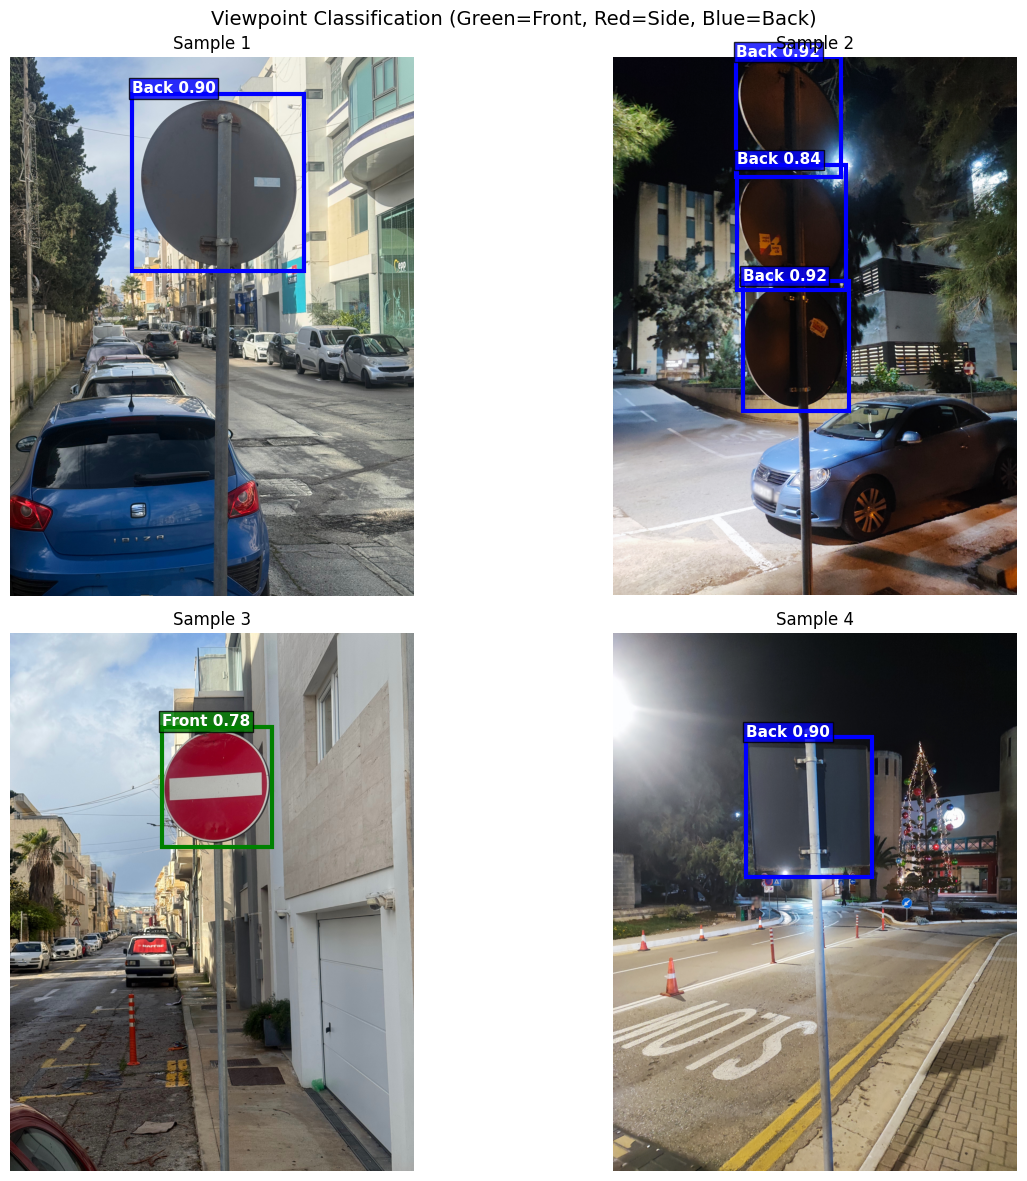

In [32]:
def visualize_results(num_samples=4):
    import matplotlib.patches as patches
    
    val_dir = Path(Config.OutputDir) / 'images' / 'val'
    images = list(val_dir.glob('*.jpg'))[:num_samples]
    
    if not images:
        images = list((Path(Config.OutputDir) / 'images' / 'train').glob('*.jpg'))[:num_samples]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    colors = {'Front': 'green', 'Side': 'red', 'Back': 'blue', 'Angle': 'orange'}
    
    for idx, img_path in enumerate(images):
        results = Model(img_path, conf=0.25)
        img = np.array(Image.open(img_path))
        
        ax = axes[idx]
        ax.imshow(img)
        
        for r in results:
            boxes = r.boxes
            if boxes is None:
                continue
            
            for i in range(len(boxes)):
                x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
                cls_id = int(boxes.cls[i])
                conf = float(boxes.conf[i])
                cls_name = Config.ViewClasses[cls_id]
                color = colors.get(cls_name, 'yellow')
                
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                        linewidth=3, edgecolor=color, 
                                        facecolor='none')
                ax.add_patch(rect)
                
                ax.text(x1, y1-5, f"{cls_name} {conf:.2f}", 
                       color='white', fontsize=11, weight='bold',
                       bbox=dict(facecolor=color, alpha=0.8, pad=2))
        
        ax.axis('off')
        ax.set_title(f"Sample {idx+1}", fontsize=12)
    
    plt.suptitle("Viewpoint Classification (Green=Front, Red=Side, Blue=Back)", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{Config.ModelDir}/viewpoint_predictions.png", dpi=300)
    plt.show()

visualize_results()

## Step Eight: Evaluation And Statistics

Running validation to calculate statistics...
Loaded model from: runs/detect/outputs/viewpoint_model/viewpoint_classifier/weights/best.pt
Ultralytics 8.4.9 🚀 Python-3.11.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660, 5748MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7678.7±1717.3 MB/s, size: 3228.3 KB)
val: Scanning /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/data/viewpoint_yolo/labels/val.cache... 121 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 121/121 46.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.3it/s 6.3s0.3ss
                   all        121        185      0.891      0.816      0.868      0.647
                 Front         50         77      0.871      0.727       0.86      0.641
                  Side         40         45       0.85      0.881      0.833       

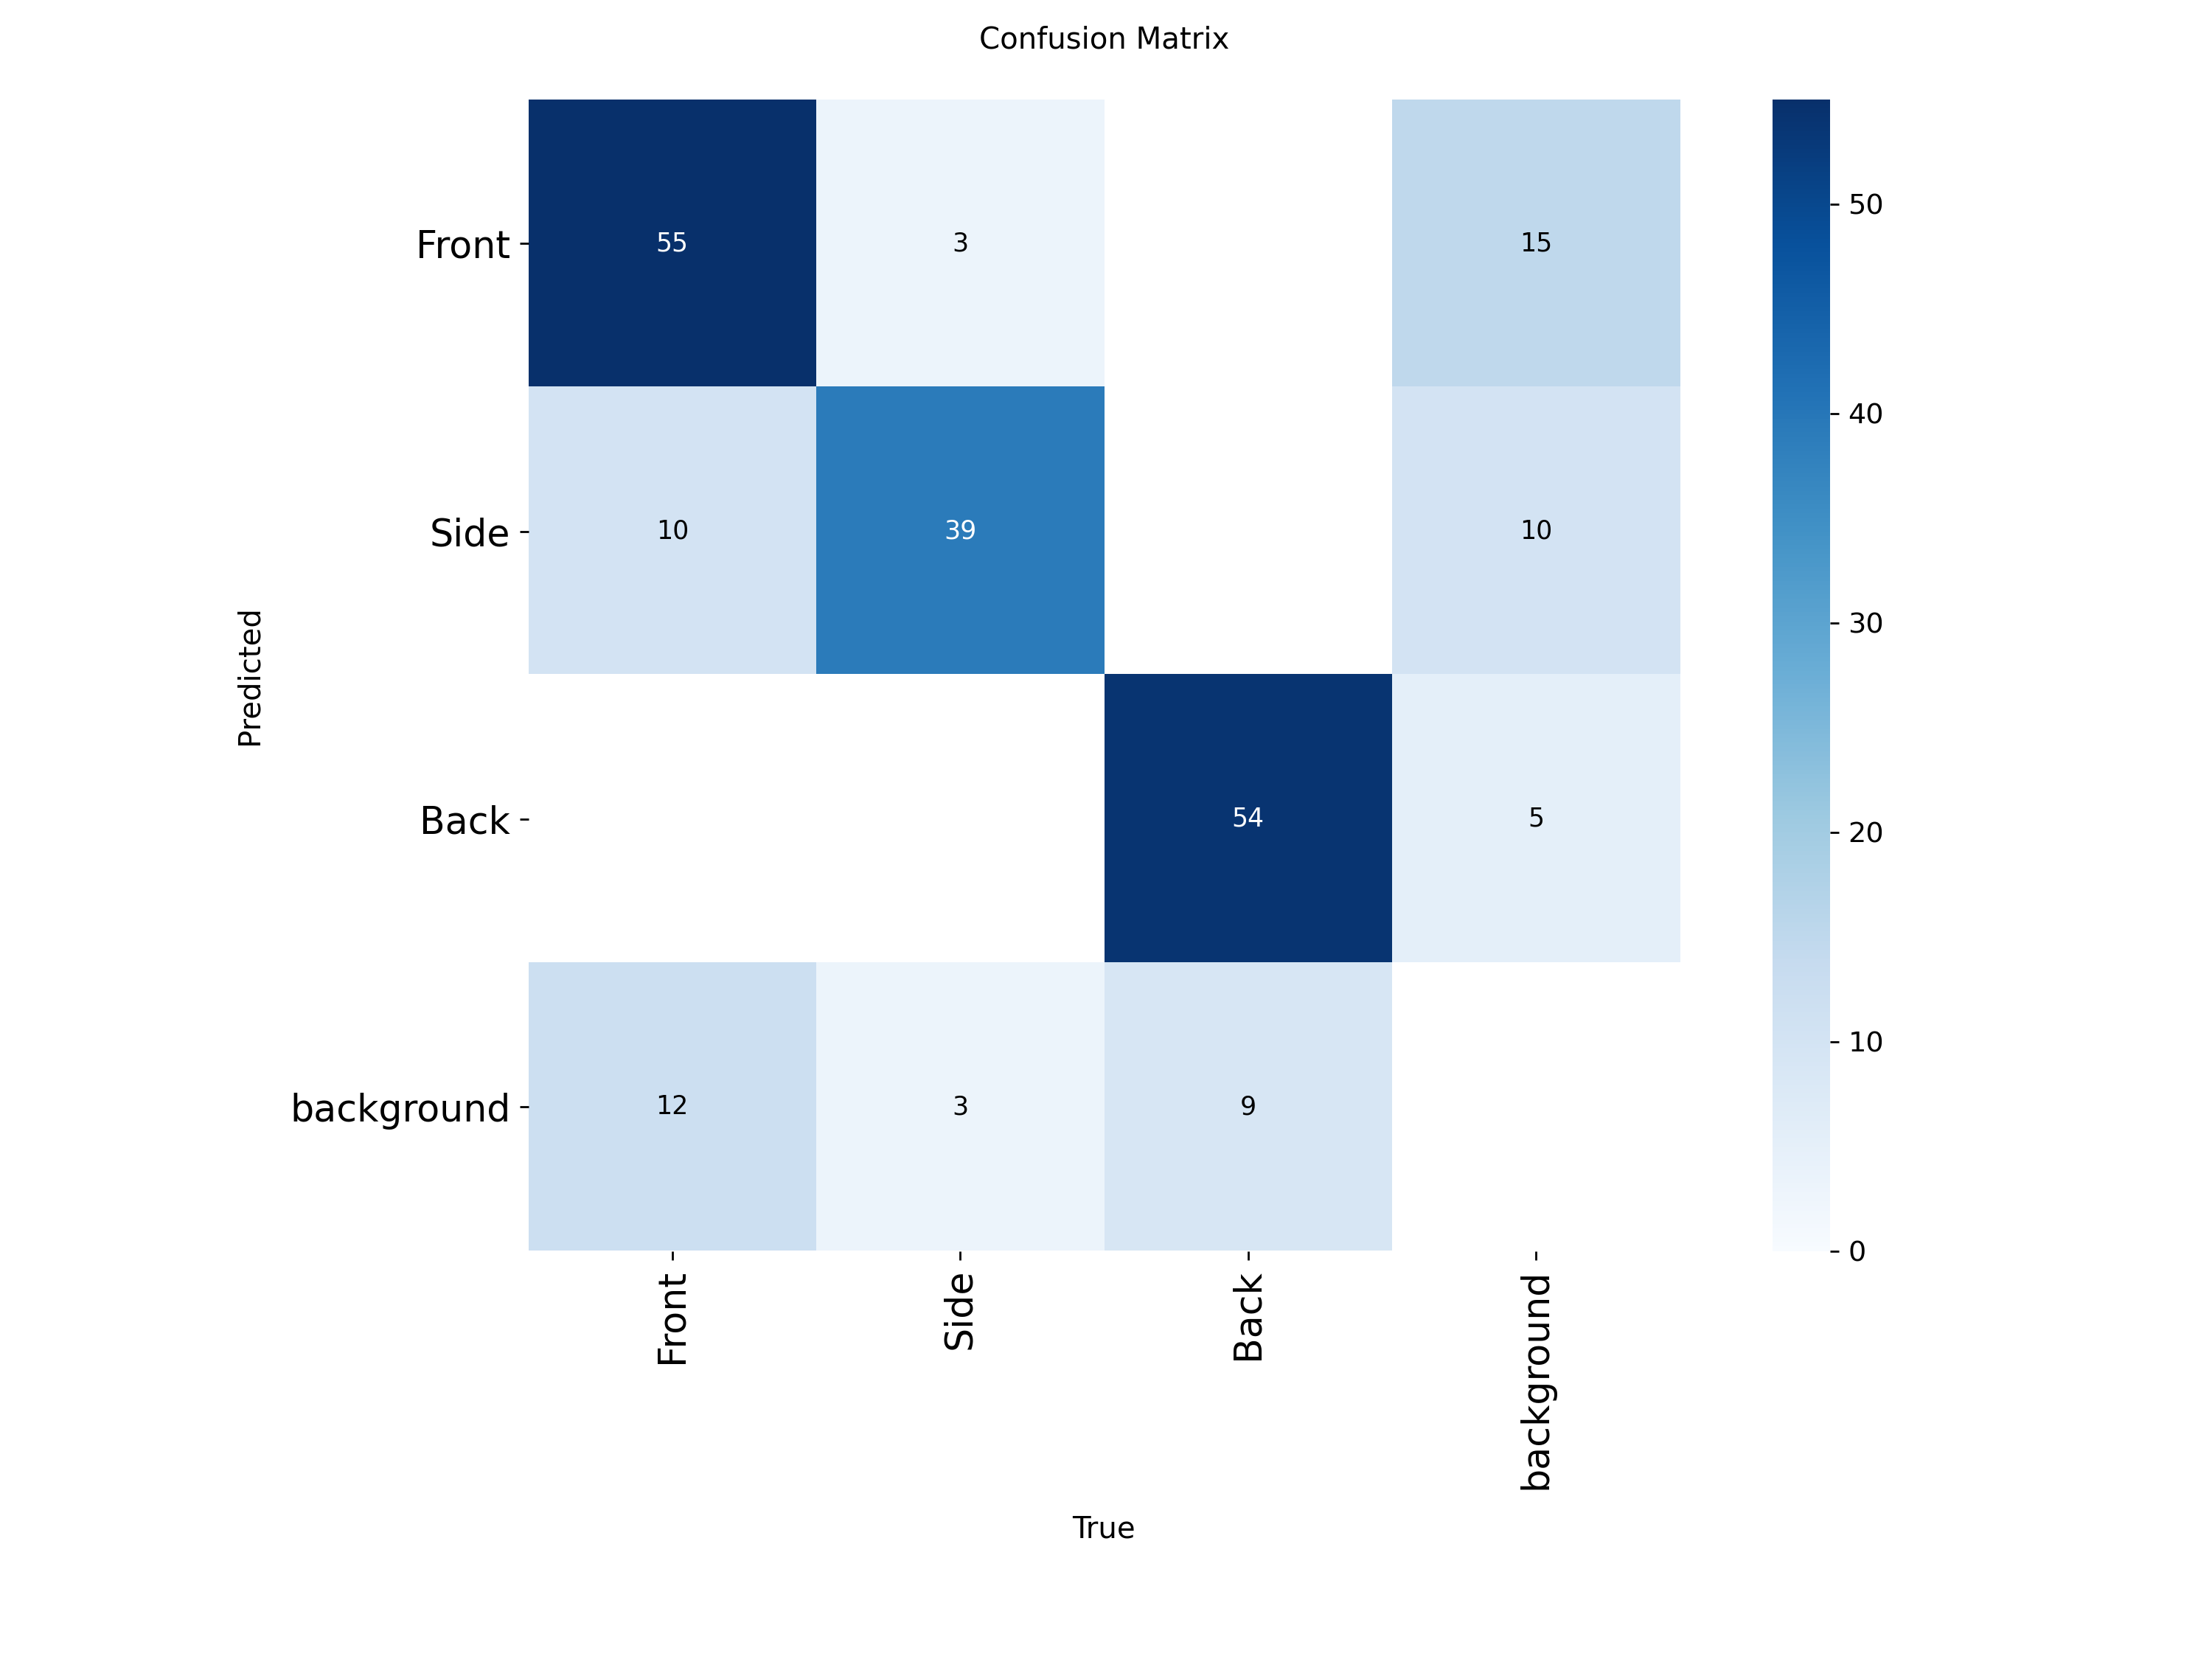

Confusion matrix saved to: /home/ataru/Documents/ImageDetection/ARI3129-SignDetectors-Classifiers/runs/detect/val2/confusion_matrix.png

Validation complete.


In [33]:
import pandas as pd
from IPython.display import Image as IPImage, display
from pathlib import Path

print("Running validation to calculate statistics...")

weightsPath = Path("runs/detect") / Config.ModelDir / "viewpoint_classifier/weights/best.pt"
if not weightsPath.exists():
    weightsPath = Path("runs/detect") / Config.ModelDir / "viewpoint_classifier/weights/last.pt"

if weightsPath.exists():
    Model = YOLO(str(weightsPath))
    print(f"Loaded model from: {weightsPath}")
else:
    print("No trained weights found. Please complete training first.")
    raise FileNotFoundError(f"Weights not found at: {weightsPath}")

metrics = Model.val(data=str(yaml_path), split='val')

print("\n--- Key Statistics ---")
print(f"mAP50 (Mean Average Precision at 0.5): {metrics.box.map50:.4f}")
print(f"mAP50-95 (Mean Average Precision at 0.5:0.95): {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

print("\n--- Per-Class Performance (mAP50-95) ---")
for i, className in enumerate(Config.ViewClasses):
    if i < len(metrics.box.maps):
        print(f"{className}: {metrics.box.maps[i]:.4f}")
    else:
        print(f"{className}: N/A (No instances in validation set)")

print("\n--- Confusion Matrix ---")
try:
    saveDir = Path(metrics.save_dir)
    cmPath = saveDir / "confusion_matrix.png"
    
    if cmPath.exists():
        display(IPImage(filename=cmPath))
        print(f"Confusion matrix saved to: {cmPath}")
    else:
        cmPathNorm = saveDir / "confusion_matrix_normalized.png"
        if cmPathNorm.exists():
            display(IPImage(filename=cmPathNorm))
            print(f"Normalized confusion matrix saved to: {cmPathNorm}")
        else:
            print(f"Confusion matrix not found at {saveDir}")
            
            altPath = Path("runs/detect") / Config.ModelDir / "viewpoint_classifier/confusion_matrix.png"
            if altPath.exists():
                display(IPImage(filename=altPath))
                print(f"Found at: {altPath}")
            
except Exception as e:
    print(f"Could not display confusion matrix: {e}")

try:
    prPath = saveDir / "PR_curve.png"
    if prPath.exists():
        print("\n--- Precision-Recall Curve ---")
        display(IPImage(filename=prPath))
        print(f"PR curve saved to: {prPath}")
except Exception as e:
    print(f"Could not display PR curve: {e}")

try:
    f1Path = saveDir / "F1_curve.png"
    if f1Path.exists():
        print("\n--- F1-Confidence Curve ---")
        display(IPImage(filename=f1Path))
except Exception as e:
    pass

print("\nValidation complete.")